<a href="https://colab.research.google.com/github/stephenbeckr/convex-optimization-class/blob/main/Demos/ConvergenceRateDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convergence rate demos
For APPM 5360, Spr '21/'23/'25, Becker

1. Warmup
2. Quadratics
3. Logistic regression and Newton's method (and linesearch)

In [14]:
import numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt
rng   = np.random.default_rng()

%reload_ext autoreload
%autoreload 2
!wget -nv 'https://github.com/stephenbeckr/convex-optimization-class/raw/main/utilities/firstOrderMethods.py'
!wget -nv 'https://github.com/stephenbeckr/convex-optimization-class/raw/main/utilities/secondOrderMethods.py'
import firstOrderMethods, secondOrderMethods

2025-03-17 16:58:35 URL:https://raw.githubusercontent.com/stephenbeckr/convex-optimization-class/main/utilities/firstOrderMethods.py [33872/33872] -> "firstOrderMethods.py.3" [1]
2025-03-17 16:58:35 URL:https://raw.githubusercontent.com/stephenbeckr/convex-optimization-class/main/utilities/secondOrderMethods.py [5876/5876] -> "secondOrderMethods.py.3" [1]


## Examples of convergence rates

| Error, $k$ &nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;| iter to $\epsilon$ sol'm &nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;| iter to $\epsilon=10^{-2}$ &nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;| iter to $\epsilon=10^{-4}$ &nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;| iter to $\epsilon=10^{-6}$&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp; |
| --- | --- | -- | --- | --- |
| $\sqrt{\frac{10^{-2}}{k}}$   | $\frac{10^{-2}}{\epsilon}$  | 100  | $10^6$  | $10^{10}$  |
| $\frac{1}{k}$ | $\frac{1}{\epsilon}$ | 100 | $10^4$ | $10^6$ |
| $\left(\frac{10}{k}\right)^2$ | $\frac{10}{\sqrt{\epsilon}}$ | 100 | $10^3$ | $10^4$ |
| $\rho^k$, $\rho=10^{-\frac{1}{50}}$ | $50\log_{10}(1/\epsilon)$ | 100 | 200 | 300 |
| $(1/10)^{2^{k-99}}$ | $\log_2(2^{99}\log_{10}(1/\epsilon))$ | 100 | 101 | 101.6 |

The first three are **sublinear**, then **linear**, then **quadratic**


# 1: Warmup: what do different rates look like? i.e., how should I scale the axes?

Using artificial data

Let the error be $e_k$ at iteration $k$

- Sublinear: $e_k \propto 1/k^\alpha$ for $\alpha > 0$
- Linear: $e_k \propto \rho^k$ for some $|\rho|<1$
- Quadratic: $e_k \propto \rho^{2^k}$ for some $|\rho|<1$

<ipython-input-15-f17cc87063a4>:10: RuntimeWarning: overflow encountered in power
  plt.plot( k, (1-1e-10)**(2**k), '-', label=r'Quadratic, $\rho=1-10^{-10}$')


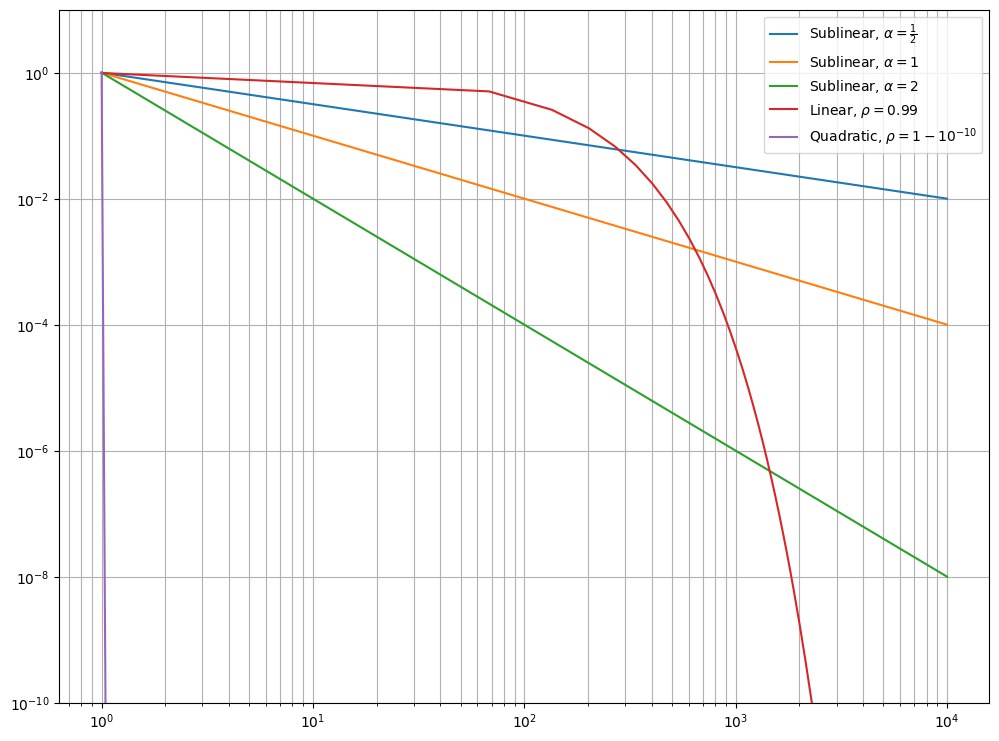

In [15]:
k = np.linspace(1,int(1e4),num=150)
# k = np.linspace(1,int(1e2),num=150) # do this to zoom in for quadratic conv.

plt.figure(figsize=(12,9))
plt.plot( k, k**(-1/2), '-', label=r'Sublinear, $\alpha=\frac{1}{2}$')
plt.plot( k, k**(-1), '-', label=r'Sublinear, $\alpha=1$')
plt.plot( k, k**(-2), '-', label=r'Sublinear, $\alpha=2$')

plt.plot( k, 0.99**k, '-', label=r'Linear, $\rho=0.99$')
plt.plot( k, (1-1e-10)**(2**k), '-', label=r'Quadratic, $\rho=1-10^{-10}$')

plt.legend()
plt.xscale('log') # toggle this on and off
plt.yscale('log')
plt.grid(True, which='both')
plt.ylim(bottom=1e-10, top=1e1)
plt.show()

- sublinear convergece (proportional to $1/k^\alpha$) is a **straight line** on a **log-log** plot
- linear convergence is a **straight line** on a **log-linear** plot
- quadratic convergence is hard to see on a plot, because it goes slowly for a while, and then it converges so fast that you only have a few iterations before you hit the limits of floating point arithmetic

# 2. Convergence rate demo on quadratics
Minimize $f(x)$ without any constraints.

We'll compare three methods
1. Gradient descent, assuming $\nabla f$ is $L$-Lipschitz continuous (so use step $t=1/L$)
2. Nesterov accelerated gradient descent (same assumptions, same stepsize)
3. **sub-gradient** descent, assuming $f$ is $\rho$-Lipschitz, that $\|x_0-x^\star\|\le B$. If we run $k$ iterations, use stepsize $t=\frac{B}{\rho\sqrt{k}}$

We'll run this to solve a quadratic problem
$$\min_x f(x) = \frac12\|Ax-b\|_2^2$$
which satisfies $\nabla f(x) = A^T(Ax-b)$ is $L$-Lipschitz continuous with $L=\|A\|^2$,
as well as a monotonic transformation of that problem
$$\min_x g(x) = \|Ax-b\|_2$$
which satisfies $g$ is $\rho$-Lipschitz with $\rho=\|A\|$, and
$\partial g(x) = \frac{A^T(Ax-b)}{\|Ax-b\|_2}$ if $Ax-b\neq 0$.

Let $A$ be $m\times n$ in size. We'll consider two cases:
1. Underdetermined, $m<n$, then $f$ is not strongly convex
2. Overdetermined, $m>n$, then if $A$ is a Gaussian, with probability 1 $f$ is strongly convex.

We expect different types of convergence:
1. sublinear, where error $\propto 1/k^\alpha$ for $\alpha>0$
2. linear, where error $\propto \rho^k$ for some $\rho = 1-1/\kappa$ or $\rho = 1- 1/\sqrt{\kappa}$.

##Solvers

In [16]:
def gradientDescent(f,grad,stepsize,x0,maxiter=1e3):
  x = x0.copy()
  fHist = []
  for k in range(int(maxiter)):
    x -= stepsize*grad(x)
    fHist.append( f(x) )
  return x, fHist

def NesterovGradientDescent(f,grad,stepsize,x0,maxiter=1e3,restart=np.inf):
  x = x0.copy()
  y = x.copy()
  fHist = []
  kk = 0
  for k in range(int(maxiter)):
    xOld = x.copy()
    x = y - stepsize*grad(y)
    kk = kk + 1
    if kk > restart:
      kk = 0
    y = x + kk/(kk+3)*(x-xOld)
    fHist.append( f(x) )
  return x, fHist

## Underdetermined case (expect gradient descent to give sublinear convergence)

In [17]:
rng   = np.random.default_rng(1)
m   = 49
n   = 50
A   = rng.normal( size=(m,n) )
xStar = np.ones( (n,1) )
#b   = rng.normal( size=(m,1) )
b   = A@xStar
L   = norm(A,ord=2)**2
# For gradient descent on 1/2||Ax-b||^2
f   = lambda x : norm(A@x-b)**2/2
grad= lambda x : A.T@( A@x-b )

fStar   = 0
x0      = np.zeros((n,1))

# And if we do subgradient descent on ||Ax-b||
# (Note: if we measure f2(x) convergence, since it's not squared
#  we'd of course at least expect sqrt() slower... )
f2  = lambda x : norm(A@x-b)
def subgrad(x):
  r = A@x-b
  return A.T@(r/norm(r))
rho  = norm(A,ord=2)
B    = norm(xStar-x0)

In [18]:
maxiter = 1e4
x_gd, fHist_gd     = gradientDescent(f,grad,1/L,x0,maxiter=maxiter)
x_Nest, fHist_Nest = NesterovGradientDescent(f,grad,1/L,x0,maxiter=maxiter)
# subgradient descent:
step = B/rho/np.sqrt(maxiter)
x_sgd, fHist_sgd   = gradientDescent(f2,subgrad,step,x0,maxiter=maxiter)

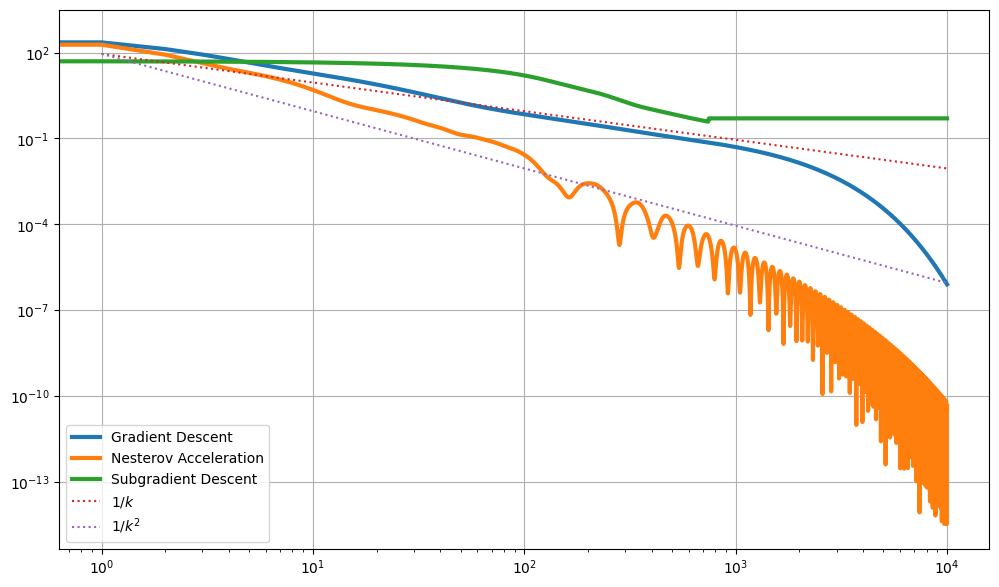

In [19]:
plt.figure(figsize=(12,7))
plt.loglog( fHist_gd, linewidth=3,label='Gradient Descent' )
plt.loglog( fHist_Nest,linewidth=3, label='Nesterov Acceleration' )
plt.loglog( fHist_sgd, linewidth=3,label='Subgradient Descent' )
k = np.arange(1,maxiter)
plt.loglog(k,90/k,':',label='$1/k$') # for reference only
plt.loglog(k,90/k**2,':',label='$1/k^2$') # for reference only
plt.legend()
plt.grid()
plt.show()

#### Question for thought:
The convergence rate of gradient descent and Nesterov acceleration seems to improve eventually.  Why?

A: This is probably because the algorithm has identified the right manifold (e.g., the support of $x^\star$) which effectively reduces the dimensionality, and hence we start acting like an over-determined least-squares problem, hence strongly convex.  See [Are we there yet? Manifold identification of gradient-related proximal methods](http://proceedings.mlr.press/v89/sun19a.html) ICML '19.

## Over-determined case, expect linear convergence

In [20]:
rng   = np.random.default_rng(1)
m   = 55
n   = 50
A   = rng.normal( size=(m,n) )
xStar = np.ones( (n,1) )
b   = A@xStar
L   = norm(A,ord=2)**2
# For gradient descent on 1/2||Ax-b||^2
f   = lambda x : norm(A@x-b)**2/2
grad= lambda x : A.T@( A@x-b )

fStar   = 0
x0      = np.zeros((n,1))

evals = np.linalg.eigvals(A.T@A)
L     = np.max(evals)
mu    = np.min(evals)
kappa = L/mu
print(f"L is {L:.2f}, mu is {mu:.2f}, condition number is {kappa:.2e}")

f2  = lambda x : norm(A@x-b)
def subgrad(x):
  r = A@x-b
  return A.T@(r/norm(r))
rho  = norm(A,ord=2)
B    = norm(xStar-x0)

L is 204.96, mu is 0.17, condition number is 1.17e+03


In [21]:
maxiter = 1e4
x_gd, fHist_gd     = gradientDescent(f,grad,1/L,x0,maxiter=maxiter)
x_Nest, fHist_Nest = NesterovGradientDescent(f,grad,1/L,x0,maxiter=maxiter)
x_Nest2, fHist_Nest2 = NesterovGradientDescent(f,grad,1/L,x0,maxiter=maxiter,restart=500)
# subgradient descent:
step = 1e0*(B/rho)/np.sqrt(maxiter)
x_sgd, fHist_sgd   = gradientDescent(f2,subgrad,step,x0,maxiter=maxiter)

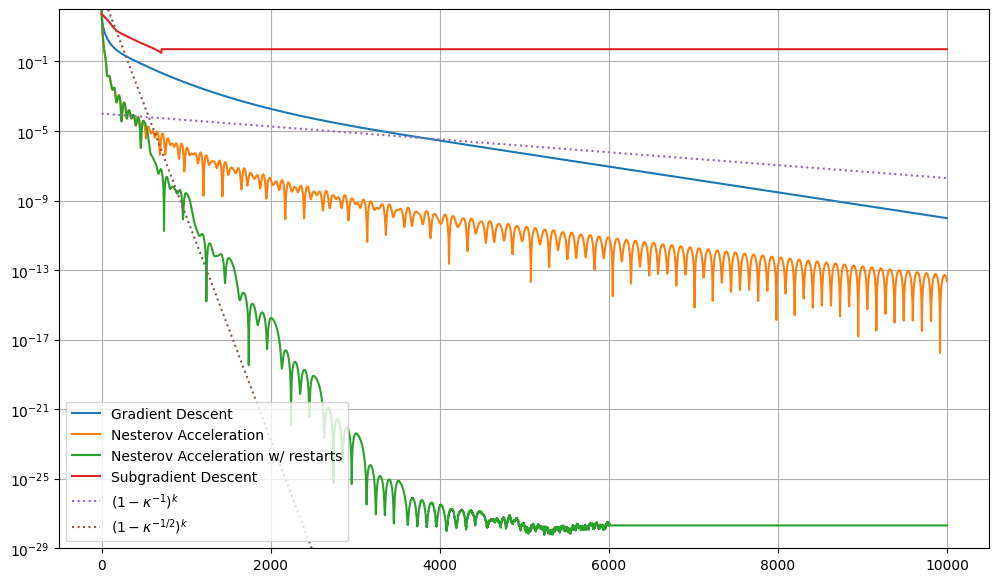

In [22]:
plt.figure(figsize=(12,7))
plt.semilogy( fHist_gd, label='Gradient Descent' )
plt.semilogy( fHist_Nest, label='Nesterov Acceleration' )
plt.semilogy( fHist_Nest2, label='Nesterov Acceleration w/ restarts' )
plt.semilogy( fHist_sgd, label='Subgradient Descent' )
k = np.arange(1,maxiter)
plt.semilogy(k,1e-4*(1-1/kappa)**k,':',label='$(1-\kappa^{-1})^k$')
plt.semilogy(k,1e3*(1-1/np.sqrt(kappa))**k,':',label='$(1-\kappa^{-1/2})^k$')
plt.ylim(bottom=1e-29,top=1e2)
plt.legend()
plt.grid()
plt.show()

# 3. Logistic regression

Based off [utilities/APPM5630_utilities.ipynb](https://github.com/stephenbeckr/convex-optimization-class/blob/master/utilities/APPM5630_utilities.ipynb)

We'll use some prebuilt gradient descent and Newton's method solvers that allow for a linesearch

Creating test problem for problem type 3
Iter.  Objective Stepsize
-----  --------- --------
    0  1.83e+01  4.79e-02
  500  2.64e-07  2.71e+06
 1000  3.64e-13  1.73e+12
 1500  5.74e-19  1.28e+18
 1624  2.06e-20  3.07e+19
==  Quitting due to norm of gradient being small  ==
Iter.  Objective Stepsize
-----  --------- --------
    0  1.83e+01  4.79e-02
  500  6.71e-01  4.79e-02
 1000  3.79e-01  4.79e-02
 1500  2.67e-01  4.79e-02
 2000  2.07e-01  4.79e-02
 2500  1.69e-01  4.79e-02
 3000  1.43e-01  4.79e-02
 3500  1.24e-01  4.79e-02
 4000  1.10e-01  4.79e-02
 4500  9.86e-02  4.79e-02
 5000  8.94e-02  4.79e-02
 5500  8.18e-02  4.79e-02
 6000  7.54e-02  4.79e-02
 6500  7.00e-02  4.79e-02
 7000  6.53e-02  4.79e-02
 7500  6.12e-02  4.79e-02
 8000  5.76e-02  4.79e-02
 8500  5.44e-02  4.79e-02
 9000  5.15e-02  4.79e-02
 9500  4.89e-02  4.79e-02
10000  4.66e-02  4.79e-02
10000  4.66e-02  4.79e-02
==  Reached max iterations  ==
Iter.  Objective Stepsize
-----  --------- --------
    0  2.05e+01  

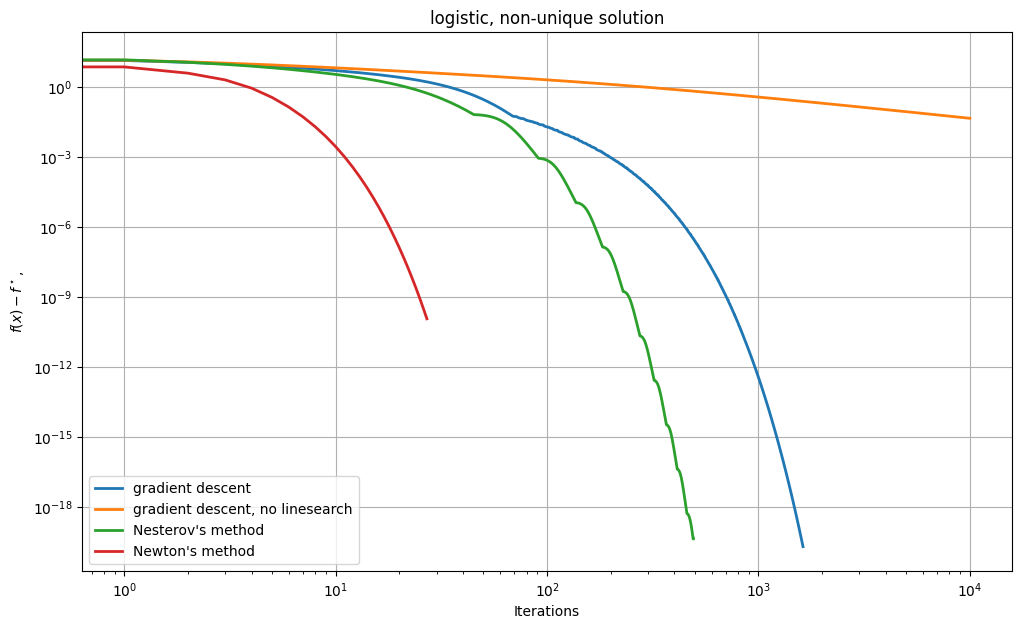

In [24]:
problemNumber = 3  # logistic regression
# case 2 is logistic with a unique solution, using CVXPY to find it
# case 3 is logistic with an interpolating solution, might have other solutions, doesn't need CVXPY
rng = np.random.default_rng(1)
prob = firstOrderMethods.createTestProblem( problemNumber, rng=rng )

xTrue = prob['xTrue']
x0  = np.zeros(prob['n'])
L   = prob['L']
NesterovAcceleration = False
x_gd, data_gd = firstOrderMethods.gradientDescent(prob['f'],prob['grad'],x0,stepsize=1/L,
                                               printEvery=None,maxIters=None,
                                               tol=1e-20, saveHistory=True, linesearch=True,
                                               acceleration=NesterovAcceleration,restart=None)
_, data_gd_noLinesearch = firstOrderMethods.gradientDescent(prob['f'],prob['grad'],x0,stepsize=1/L,
                                               printEvery=None,maxIters=None,
                                               tol=1e-20, saveHistory=True, linesearch=False,
                                               acceleration=NesterovAcceleration,restart=None)

NesterovAcceleration = True
x_Nesterov, data_Nesterov = firstOrderMethods.gradientDescent(prob['f'],prob['grad'],x0,stepsize=1/L,
                                               printEvery=None,maxIters=None,
                                               tol=1e-20, saveHistory=True, linesearch=True,
                                               ArmijoLinesearch=False,
                                               acceleration=NesterovAcceleration,restart=45)

x_Newton, data_Newton = secondOrderMethods.NewtonsMethod( prob['f'],prob['grad'],prob['Hess'],
                                          x0,tol=1e-10,
                                          saveHistory=True,maxIters=100)

plt.figure(figsize=(12,7))
plt.semilogy(  data_gd['fcnHistory']-prob['fTrue'] , label='gradient descent',linewidth=2)
plt.semilogy(  data_gd_noLinesearch['fcnHistory']-prob['fTrue'] , label='gradient descent, no linesearch',linewidth=2)
plt.semilogy(  data_Nesterov['fcnHistory']-prob['fTrue'] , label="Nesterov's method",linewidth=2)
plt.semilogy(  data_Newton['fcnHistory']-prob['fTrue'] , label="Newton's method",linewidth=2)
plt.xscale("log")
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel(r'$f(x)-f^\star$,')
plt.legend()
plt.title(prob['name'])
plt.show()